# General Linear Regression: Poisson Regression

*Author: Evan Carey*

*Copyright 2017, BH Analytics, LLC*

## Overview

The purpose of this section is to explore Poisson regression in the context of python, specifically statsmodels. We will begin by understanding exactly what Poisson regression is, and then fit increasingly complex models to make inference on the mean value of a count outcome. This is part of the general linear model family, using the link function with a Poisson distribution. 

## Libraries

In [1]:
## Import Modules
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
import seaborn as sns
import textwrap

In [2]:
## Enable inline plotting for graphics
%matplotlib inline

In [3]:
print(textwrap.fill(sys.version),'\n')
print("Pandas version: {0}".format(pd.__version__),'\n')
print("Matplotlib version: {0}".format(matplotlib.__version__),'\n')
print("Numpy version: {0}".format(np.__version__),'\n')
print("Statsmodels version: {0}".format(statsmodels.__version__))

3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC
v.1900 64 bit (AMD64)] 

Pandas version: 0.19.2 

Matplotlib version: 2.0.0 

Numpy version: 1.11.3 

Statsmodels version: 0.6.1


## Check your working directory

Subsequent sessions may require you to identify and update your working directory so paths correctly point at the downloaded data files. You can check your working directory like so:

In [4]:
# Working Directory
import os
print("My working directory:\n" + os.getcwd())
# Set Working Directory (if needed)
os.chdir(r"J:\Sync\Work\BHAnalytics\Python")
print("My new working directory:\n" + os.getcwd())

My working directory:
J:\Sync\Work\BHAnalytics\Python\01_Current_Python\notebooks
My new working directory:
J:\Sync\Work\BHAnalytics\Python


## General Linear Models

We can generalize the ordinary linear model to a more flexible framework. In regular regression, the predictor variables are on the same scale as the outcome, and we are estimating the mean value of the outcome. We assume the sample means are normally distributed with some error. The equation for K predictors on an outcome looks like this:

$$ E(Y|X)=\beta_0 + \beta_1*X_1 + \beta_2*X_2 + ... + \beta_k*X_k + e $$

A more general framework would be to allow some function to link the predictors to the outcome (instead of assuming they are on the same scale). This is called the link function, and in normal regression it is the identity function. We can also consider different distributional families (other than normal) for the outcome. The combination of generalizing the link function and the distributional family is called a general linear model.

## Poisson Regression

In Poisson regression, we are modeling a  count outcome. The outcome takes on discrete values greater than or equal to zero. The distributional family we use is the Poisson distribution. The only parameter in a Poisson distribution is lambda ($\lambda$). Lambda is both the mean and the variance for the Poisson distribution. The link function we use here is the log function. Thus, our predictor variables (and the associated beta coefficients) are on the log scale, not on the outcome scale!.

$$ log(E(Y | X)) = \beta_0 + \beta_1*X_1 + \beta_2*X_2 + ... + \beta_k*X_k$$

* What is our target of inference in this model?
* Where is the error term?

We can do some algebraice manipulations to find the expected value of the outcome by taking the exponent of both sides of the equation:

$$ E(Y | X) = e^{\beta_0 + \beta_1*X_1 + \beta_2*X_2 + ... + \beta_k*X_k}$$


## The Poisson Distribution

Let's take a moment to further understand the Poisson distribution. We can use numpy to simulate some data from the Poisson distribution with different means. As we noted above, there is a single paramater, $\lambda$, which is both the mean and the variance. We will start with 1000 realizations from a Poisson distribution with $\lambda = 1$.

In [5]:
np.random.seed(12)
samp1 = pd.DataFrame({'outcome':np.random.poisson(1,1000)})

In [6]:
np.mean(samp1)

outcome    0.995
dtype: float64

In [7]:
np.var(samp1)

outcome    0.964975
dtype: float64

As expected, both the mean and the variance are (nearly) equal to 1. We can also view the distribution like so:

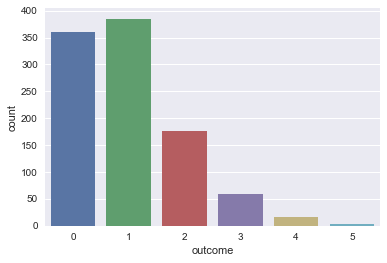

In [8]:
sns.countplot(samp1.outcome)

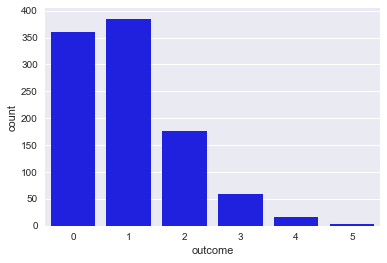

In [9]:
sns.countplot(samp1.outcome, color='blue')

C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


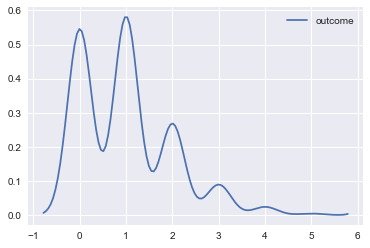

In [10]:
sns.kdeplot(samp1.outcome)

C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


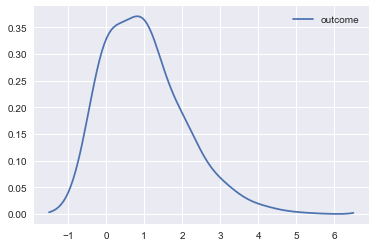

In [11]:
sns.kdeplot(samp1.outcome,
            bw=0.5)

What happens if we increase lambda to 10? We should expect a mean and variance equal to 5. 

In [12]:
np.random.seed(12)
samp2 = pd.DataFrame({'outcome':np.random.poisson(10,1000)})

In [13]:
np.mean(samp2)

outcome    9.883
dtype: float64

In [14]:
np.var(samp2)

outcome    9.235311
dtype: float64

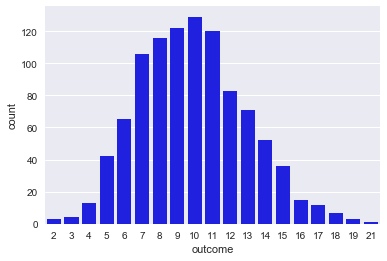

In [15]:
sns.countplot(samp2.outcome,color='blue')

C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


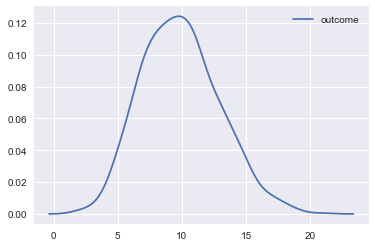

In [16]:
sns.kdeplot(samp2.outcome)

## Fitting Our First Poisson Model

We can use these two distributions to fit our first Poisson models and better understand the link between the estimated model coefficients and the underlying distribution of data. Let's start with an intercept only model for each sample (null model). Here is the equation we are fitting as a reminder:


$$ log(E(Y | X)) = \beta_0 $$


We can express this with the mean on the left hand side like so:

$$ E(Y | X) = e^{\beta_0}$$


In [17]:
## Fit simple models on this data
samp1_mod = smf.glm('outcome ~ 1',
              data=samp1,
              family=sm.families.Poisson()).fit()
print(samp1_mod.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      999
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1293.6
Date:                Sun, 23 Apr 2017   Deviance:                       1115.4
Time:                        17:21:17   Pearson chi2:                     970.
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0050      0.032     -0.158      0.874        -0.067     0.057


The estimate for the intercept here is -0.0050. Why isn't it 1? Because the betas are on the log scale! In order to get the mean value of the outcome in this model, we must exponentiate the beta:

$$ E(Y | X) = e^{\beta_0}$$

$$ E(Y | X) = e^{-0.005}$$

In [18]:
## Recover coef
samp1_mod.params

Intercept   -0.005013
dtype: float64

In [19]:
np.exp(samp1_mod.params[0])

0.995

Let's fit the other model on the distributon with $\lambda = 10$

In [20]:
samp2_mod = smf.glm('outcome ~ 1',
              data=samp2,
              family=sm.families.Poisson()).fit()
print(samp2_mod.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      999
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2521.3
Date:                Sun, 23 Apr 2017   Deviance:                       946.21
Time:                        17:21:17   Pearson chi2:                     934.
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.2908      0.010    227.738      0.000         2.271     2.311


In [21]:
## Estimate mean
np.exp(samp2_mod.params[0])

9.8830000000000027

In [22]:
## Compare to mean
samp2.mean()

outcome    9.883
dtype: float64

In [23]:
## Compare to Variance
samp2.var()

outcome    9.244556
dtype: float64

## Applied Poisson Regression Example: The Rand Health Data

We will use the Rand Health data that is included with statsmodels for the applied section of Poisson modelling. You can call the data into memory using the following code:

In [24]:
## Import Data
rand_hie = statsmodels.datasets.randhie.load_pandas().data

We can examine information about the data like so:

In [25]:
print(statsmodels.datasets.randhie.NOTE)

::

    Number of observations - 20,190
    Number of variables - 10
    Variable name definitions::

        mdvis   - Number of outpatient visits to an MD
        lncoins - ln(coinsurance + 1), 0 <= coninsurance <= 100
        idp     - 1 if individual deductible plan, 0 otherwise
        lpi     - ln(max(1, annual participation incentive payment))
        fmde    - 0 if idp = 1; ln(max(1, MDE/(0.01 coinsurance))) otherwise
        physlm  - 1 if the person has a physical limitation
        disea   - number of chronic diseases
        hlthg   - 1 if self-rated health is good
        hlthf   - 1 if self-rated health is fair
        hlthp   - 1 if self-rated health is poor
        (Omitted category is excellent self-rated health)



As always, let's first check the top and bottom of the data and some basic descriptions:

In [26]:
rand_hie.head()

mdvis  lncoins  idp       lpi  fmde  physlm     disea  hlthg  hlthf  hlthp
0      0  4.61512    1  6.907755   0.0     0.0  13.73189      1      0      0
1      2  4.61512    1  6.907755   0.0     0.0  13.73189      1      0      0
2      0  4.61512    1  6.907755   0.0     0.0  13.73189      1      0      0
3      0  4.61512    1  6.907755   0.0     0.0  13.73189      1      0      0
4      0  4.61512    1  6.907755   0.0     0.0  13.73189      1      0      0

In [27]:
rand_hie.tail()

mdvis   lncoins  idp       lpi      fmde    physlm     disea  hlthg  \
20185      2  0.000000    0  5.377498  0.000000  0.144292  10.57626      0   
20186      0  0.000000    0  5.377498  0.000000  0.144292  10.57626      0   
20187      8  3.258096    0  6.874819  8.006368  0.144292  10.57626      0   
20188      8  3.258096    0  5.156178  6.542472  0.144292  10.57626      0   
20189      6  3.258096    0  6.620073  8.006368  0.144292  10.57626      0   

       hlthf  hlthp  
20185      0      0  
20186      0      0  
20187      0      0  
20188      0      0  
20189      0      0

In [28]:
rand_hie.dtypes

mdvis        int64
lncoins    float64
idp          int64
lpi        float64
fmde       float64
physlm     float64
disea      float64
hlthg        int64
hlthf        int64
hlthp        int64
dtype: object

In [29]:
## Describe data
rand_hie.describe()

mdvis       lncoins           idp           lpi          fmde  \
count  20190.000000  20190.000000  20190.000000  20190.000000  20190.000000   
mean       2.860426      1.774071      0.259980      4.707894      4.029524   
std        4.504365      1.983272      0.438634      2.697840      3.471353   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      4.063885      0.000000   
50%        1.000000      0.000000      0.000000      6.109248      6.093520   
75%        4.000000      3.931826      1.000000      6.620073      6.959049   
max       77.000000      4.615120      1.000000      7.163699      8.294049   

             physlm         disea         hlthg         hlthf         hlthp  
count  20190.000000  20190.000000  20190.000000  20190.000000  20190.000000  
mean       0.123500     11.244492      0.362011      0.077266      0.014958  
std        0.322016      6.741449      0.480594      0.267020      0.121387  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        0.000000      6.900000      0.000000      0.000000      0.000000  
50%        0.000000     10.576260      0.000000      0.000000      0.000000  
75%        0.000000     13.731890      1.000000      0.000000      0.000000  
max        1.000000     58.600000      1.000000      1.000000      1.000000

We will be focusing on the outcome 'mdvis', which is the number of doctors visits. Let's further examine this variable:

In [30]:
rand_hie.mdvis.mean()

2.860425953442298

In [31]:
rand_hie.mdvis.var()

20.289300130606083

Is the assumption of mean = variance reasonable here? 

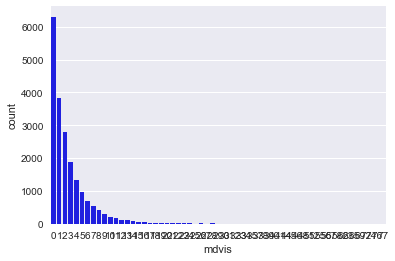

In [32]:
## Examine outcome
sns.countplot(rand_hie.mdvis,color='blue')

## RAND Data: Null Model

The first model we will fit is the null model, or the intercept only model. 

In [33]:
## Fit basic glm with Poisson
mod0 = smf.glm('mdvis ~ 1',
              data=rand_hie,
              family=sm.families.Poisson()).fit()
print(mod0.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  mdvis   No. Observations:                20190
Model:                            GLM   Df Residuals:                    20189
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -66647.
Date:                Sun, 23 Apr 2017   Deviance:                       92389.
Time:                        17:21:17   Pearson chi2:                 1.43e+05
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.0510      0.004    252.566      0.000         1.043     1.059


We can interpret the exponentiating intercept as the estimate of the mean:

In [34]:
## Estimate mean
np.exp(mod0.params)

Intercept    2.860426
dtype: float64

In [35]:
rand_hie.mdvis.mean()

2.860425953442298

Notice the estimate of the mean is unbiased, even though the variance is likely underestimated. This data is very overdispersed (extra variation beyond the Poisson assumption). We will talk more on this later!

In [36]:
rand_hie.mdvis.var()

20.289300130606083

## Add Predictors into the Model

In [37]:
## Examine potential predictors
rand_hie.dtypes

mdvis        int64
lncoins    float64
idp          int64
lpi        float64
fmde       float64
physlm     float64
disea      float64
hlthg        int64
hlthf        int64
hlthp        int64
dtype: object

In [38]:
rand_hie.corr()

mdvis   lncoins       idp       lpi      fmde    physlm     disea  \
mdvis    1.000000 -0.069671 -0.050951 -0.016567 -0.097686  0.143470  0.211956   
lncoins -0.069671  1.000000 -0.247990  0.404666  0.549927 -0.014228  0.031818   
idp     -0.050951 -0.247990  1.000000  0.121087  0.047311 -0.018526  0.008035   
lpi     -0.016567  0.404666  0.121087  1.000000  0.501078 -0.024966  0.000033   
fmde    -0.097686  0.549927  0.047311  0.501078  1.000000 -0.005385 -0.035693   
physlm   0.143470 -0.014228 -0.018526 -0.024966 -0.005385  1.000000  0.310483   
disea    0.211956  0.031818  0.008035  0.000033 -0.035693  0.310483  1.000000   
hlthg    0.007005  0.010855  0.026975 -0.009360  0.000613  0.051993  0.099506   
hlthf    0.053443 -0.005129 -0.002778 -0.018871 -0.004346  0.200233  0.140983   
hlthp    0.080276 -0.031352 -0.001408 -0.014567 -0.026437  0.184110  0.130947   

            hlthg     hlthf     hlthp  
mdvis    0.007005  0.053443  0.080276  
lncoins  0.010855 -0.005129 -0.031352  
idp      0.026975 -0.002778 -0.001408  
lpi     -0.009360 -0.018871 -0.014567  
fmde     0.000613 -0.004346 -0.026437  
physlm   0.051993  0.200233  0.184110  
disea    0.099506  0.140983  0.130947  
hlthg    1.000000 -0.217977 -0.092824  
hlthf   -0.217977  1.000000 -0.035659  
hlthp   -0.092824 -0.035659  1.000000

We will start by examining idp, which is binary variable indicating if the individual is on the deductible plan or not. First, let's calculate the group by means:

In [39]:
rand_hie.groupby('idp').mdvis.mean()

idp
0    2.996453
1    2.473233
Name: mdvis, dtype: float64

It looks like patients with an individual deductable plan have a lower mean number of physicians visits (the difference is about 0.52). Let's fit the same model using a Poisson regression. Here is the model we are fitting:


$$ log(\overline{mdvis}) = \beta_0 + \beta_{idp} * idp $$


What do you expect to get for the value of $\beta_0$? What about $\beta_{idp}$?

In [40]:
## Fit idp model
mod1= smf.glm('mdvis ~ idp',
              data=rand_hie,
              family=sm.families.Poisson()).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  mdvis   No. Observations:                20190
Model:                            GLM   Df Residuals:                    20188
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -66455.
Date:                Sun, 23 Apr 2017   Deviance:                       92006.
Time:                        17:21:18   Pearson chi2:                 1.43e+05
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.0974      0.005    232.204      0.000         1.088     1.107
idp           -0.1919      0.010    -19.251      0.0

Here are the model estimates:


$$ log(\overline{mdvis}) = 1.097 - 0.192 * idp $$


We are expecting an absolute difference of about 0.52 for this model. Why did we get -0.192? Because the betas are on the log scale. Instead of fitting an additive model, we have fit a multiplicative model. With some algebra, we can show the following is true:

$$ \overline{mdvis} = e^{\beta_0 + \beta_{idp} * idp} $$


$$ \overline{mdvis} = e^{\beta_0} * e^{\beta_{idp} * idp} $$

Therefore, the appropriate interpretation of of the beta coefficients for idp is multiplicative. If we exponentiate the beta, we get the multiplicative effect of idp. In this case it is:

$$e^{\beta_{idp} * idp}$$

In [41]:
mod1.params['idp']

-0.19190296004281371

In [42]:
np.exp(mod1.params['idp'])

0.82538696012084767

We can say that patients with status idp == 1 have mean mdvis that is changed by a factor of 0.82 (or a decrease of about 18%).  

In [43]:
res1 = rand_hie.groupby('idp').mdvis.mean()
res1

idp
0    2.996453
1    2.473233
Name: mdvis, dtype: float64

In [44]:
(res1[1] - res1[0]) / res1[0]

-0.17461303987915117

We can see that this is true in our basic calculations outside of the model as well. 

## Adding More Predictors Into the Model

We can add even more predictors into the model, just as we might with other forms of general linear regression. All the prior lessons on non-linearity, confounding, and interaction apply here. For now I will just fit a model with linear terms and no interactions.

In [45]:
## Fit more variables in the model
mod2 = smf.glm('mdvis ~ lncoins + idp + lpi + fmde + physlm + disea',
              data=rand_hie,
              family=sm.families.Poisson()).fit()
print(mod2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  mdvis   No. Observations:                20190
Model:                            GLM   Df Residuals:                    20183
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -62458.
Date:                Sun, 23 Apr 2017   Deviance:                       84011.
Time:                        17:21:18   Pearson chi2:                 1.27e+05
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.6924      0.011     64.019      0.000         0.671     0.714
lncoins       -0.0533      0.003    -18.491      0.0

In this model all of the variables are significant predictors of the outcome. Did IDP become stronger or weaker once we added in the other variables?

All of these coefficients can be interpreted similary as how we did the binary variable above. Let's repeat the interpretation for idp:

In [46]:
np.exp(mod2.params)

Intercept    1.998421
lncoins      0.948095
idp          0.779509
lpi          1.036165
fmde         0.965882
physlm       1.341430
disea        1.035370
dtype: float64

Now IDP is associated with a change in the mean number of MD visits by a factor of 0.77 (a decrease). Conversely, Physlm (physical limiation) shows a positive effect. The mean number of MD Visits for Patients with a physical limitation is 34% higher compared to those without a physical limitation. The number of chronic diseases is also associated with the mean number of physician visits. For every additional chronic disease (disea), the mean number of physician visits increases by 3.5%. I will leave the rest of the interpretations as an exercise to the reader.